# Bistatic RCS generated by dielectric spheres

In this notebook, we consider the bistatic radar cross section generated from plane wave scattering by an array of dielectric spheres $\Omega_j$, each with its individual permittivity $\epsilon_j$ and permeability $\mu_j$.

We denote by $\epsilon_{0}$ and $\mu_0$ the electric permittivity and magnetic permeability in vacuum, and by $\epsilon_{r, j} = \frac{\epsilon_j}{\epsilon_0}$ and $\mu_{r, j} = \frac{\mu_j}{\mu_0}$ the relative permittivity and relative permeability for each dielectric object. Denote by $\mathbf{E}^\text{s}$, $\mathbf{H}^\text{s}$ the scattered electric and magnetic field in the exterior of the scatterers. Moreover, let $\mathbf{E}^{+}$ and $\mathbf{H}^{+}$ be the total exterior fields. Correspondingly, we denote the interior fields in the $j$th obstacle by $\mathbf{E}_j$ and $\mathbf{H}_j$.

For a given medium, the Maxwell equations are given by
\begin{align}
\nabla\times \mathbf{E} &= \mathrm{i}\omega\mu \mathbf{H},\nonumber\\
\nabla\times \mathbf{H} &= -\mathrm{i}\omega\epsilon \mathbf{E}.\nonumber
\end{align}
We define the wavenumber $k$ by $k=\omega\sqrt{\mu\epsilon}$.


The electric field equations for the dielectric scattering problem now take the form
\begin{align}
\nabla\times\nabla\times \mathbf{E}^{+}(x) - k_0^2\mathbf{E}^{+}(x) &= 0,~x\in\Omega^{+}\nonumber\\
\nabla\times\nabla \times \mathbf{E}_{j}(x) - k_j^2\mathbf{E}_{j}(x) &= 0,~x\in\Omega_j\nonumber\\
\end{align}
with $k_0 = \omega\sqrt{\epsilon_0\mu_0}$ and $k_j = k_0\sqrt{\epsilon_{r,j}\mu_{r,j}}$. We define the tangential trace  $\gamma_t\mathbf{E} = \mathbf{E}\times n$ and the Neumann trace $\gamma_N = \frac{1}{ik}\gamma_t\left[\nabla\times \mathbf{E}\right]$. The exterior field $\mathbf{E}^{+}$ is the sum of the incident wave $\mathbf{E}^{inc}$ and the scattered wave $\mathbf{E}^{s}$.


Now let $ V := \begin{bmatrix}\gamma_t \mathbf{E}\\ \rho\gamma_N\mathbf{E}\end{bmatrix}$, where $\rho := \sqrt{\epsilon_r}/\sqrt{\mu_r}$. With $V_j^{+}$ being the exterior trace data (using $\epsilon_0$ and $\mu_0$) on the boundary the $j$th scatterer, and $V_j^{-}$ the corresponding interior trace data (using $\epsilon_{r, j}$ and $\mu_{r, j}$) the correct boundary condition for this scattering problem is
$$
V_j^{-} = V_j^{+}.
$$
It is immediately visible that this condition satisfies $\gamma_t\mathbf{E}_j^{-} = \gamma_t\mathbf{E}_j^{+}$. Furthermore, this condition implies that $\rho^{-}\gamma_N \mathbf{E}_j^{-} = \rho^{+}\gamma_N \mathbf{E}_j^{+}$, which is equivalent to $\mathbf{H}_j^{-} = \mathbf{H}_j^{+}$. We now define the scaled multitrace operator $A = \begin{bmatrix} M & \rho^{-1}T\\ -\rho T & M\end{bmatrix}$ with $M$ the magnetic field operator and $T$ the electric field operator. For this scaled multitrace operator it holds that
$$
\begin{bmatrix}\frac{1}{2}I - A^{+}_{j}\end{bmatrix}V_j^{+} - \sum_{i\neq j}A_{j, i}V_i^{+} = V_j^{s}.
$$
Here, $A_j^{+}$ is the multitrace operator in vacuum ($\rho = 1$) and $A_{j, i}$ is the multitrace operator with domain on the boundary of the $i$th scatterer and range on the boundary of the $j$th scatterer. This accounts for the influence of the other scatterers in a multi-scattering configuration. The data $V_j^{s}$ is the trace data of the scattered wave on the $j$th scatterer. Further, on the boundary of $\Omega_j$ we have for the interior trace data that 
$$
\begin{bmatrix}\frac{1}{2}I + A_j^{-}\end{bmatrix}V_j^{-} = V_j^{-}
$$ 
with $A_j^{-}$ being the scaled multitrace operator for the interior problem and $V_j^{-}$ the corresponding interior trace data. Using the boundary conditions $V_j^{-} = V_j^{+}$ and the fact that $V_j^{inc} = V_j^{+} - V_j^{s}$ for the trace data $V_j^{inc}$ of the incident wave the interior and exterior equations combined result in
$$
\begin{bmatrix}A_j^{-} + A_j^{+}\end{bmatrix}V_j^{+} + \sum_{i\neq j}A_{j, i}V_i^{+} = V_j^{inc}.
$$
Taking all corresponding equations over the $N$ scatterers we arrive at a complete system of equations for the unknown data $V_j$ on each scatterer.

We start with the usual imports and enable console logging.

In [1]:
import bempp.api
import numpy as np

bempp.api.enable_console_logging()
# bempp.api.pool.create_device_pool("AMD")

<StreamHandler stderr (INFO)>

For this notebook we will use two spheres of radius 0.4, centered at $-1$ and $1$ on the x-axis.

In [2]:
sphere0 = bempp.api.shapes.sphere(r=.4, origin=(-1., 0, 0), h=.2)
sphere1 = bempp.api.shapes.sphere(r=.4, origin=(1., 0, 0), h=.2)


bempp:HOST:INFO: Created grid with id 47f6b0d4-bb5e-4972-a37d-342995c20f37. Elements: 230. Edges: 345. Vertices: 117
bempp:HOST:INFO: Created grid with id 7aec9acd-b20b-4163-b8d8-2f77d2c1b64d. Elements: 232. Edges: 348. Vertices: 118


We now define the associated constants and material parameters. We have chosen the material parameters for Teflon. The overall simulation will be running at a frequency of 300Mhz.

In [3]:
frequency = 300E6 # 300Mhz

vacuum_permittivity = 8.854187817E-12
vacuum_permeability = 4 * np.pi * 1E-7

eps_r = 2.1
mu_r = 1.0

k_ext = 2 * np.pi * frequency * np.sqrt(vacuum_permittivity * vacuum_permeability)
k_int = k_ext * np.sqrt(eps_r * mu_r)

We now assemble the incident wave field. To that affect we choose a z-polarized plane wave travelling at an inciden angle theta in the (x,y) plane.

In [4]:
theta = np.pi / 4 # Incident wave travelling at a 45 degree angle
direction = np.array([np.cos(theta), np.sin(theta), 0])
polarization = np.array([0, 0, 1.0])

def plane_wave(point):
    return polarization * np.exp(1j * k_ext * np.dot(point, direction))

@bempp.api.complex_callable
def tangential_trace(point, n, domain_index, result):
    value = polarization * np.exp(1j * k_ext * np.dot(point, direction))
    result[:] =  np.cross(value, n)

@bempp.api.complex_callable
def neumann_trace(point, n, domain_index, result):
    value = np.cross(direction, polarization) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, direction))
    result[:] =  1./ (1j * k_ext) * np.cross(value, n)


We now create all the interior and exterior multitrace operators and setup the left-hand side blocked operator.

In [5]:
from bempp.api.operators.boundary.maxwell import multitrace_operator
from bempp.api.operators.boundary.sparse import multitrace_identity

A0_int = multitrace_operator(
    sphere0, k_int, epsilon_r=eps_r, mu_r=mu_r, space_type='all_rwg')
A1_int = multitrace_operator(
    sphere1, k_int, epsilon_r=eps_r, mu_r=mu_r, space_type='all_rwg')
A0_ext = multitrace_operator(
    sphere0, k_ext, space_type='all_rwg')
A1_ext = multitrace_operator(
    sphere1, k_ext, space_type='all_rwg')
A01 = multitrace_operator(sphere1, k_ext, target=sphere0, space_type='all_rwg')
A10 = multitrace_operator(sphere0, k_ext, target=sphere1, space_type='all_rwg')


A = bempp.api.GeneralizedBlockedOperator([[A0_int + A0_ext, A01],
                                          [A10, A1_int + A1_ext]])

bempp:HOST:INFO: Created grid with id 23e14c25-a78e-4733-88f6-af0e470bfaf1. Elements: 1380. Edges: 2070. Vertices: 692
bempp:HOST:INFO: Created grid with id 054f65ee-641d-439c-8565-08bb232eb745. Elements: 1392. Edges: 2088. Vertices: 698


The following code assembles the right-hand sides.

In [6]:
rhs = [bempp.api.GridFunction(space=A.range_spaces[0], dual_space=A.dual_to_range_spaces[0], fun=tangential_trace),
       bempp.api.GridFunction(space=A.range_spaces[1], dual_space=A.dual_to_range_spaces[1], fun=neumann_trace),
       bempp.api.GridFunction(space=A.range_spaces[2], dual_space=A.dual_to_range_spaces[2], fun=tangential_trace),
       bempp.api.GridFunction(space=A.range_spaces[3], dual_space=A.dual_to_range_spaces[3], fun=neumann_trace)]

We now have everything in place to solve the resulting scattering problem. Here, we solve directly with LU decomposition. For larger problems iterative solvers with preconditioning is appropriate.

In [7]:
bempp.api.enable_console_logging()
sol = bempp.api.linalg.lu(A, rhs)

In the following we visualize the near-field. For this we evaluate the interior and exterior field using the Stratton-Chu representation formula.

In [8]:
# Number of points in the x-direction
nx = 200

# Number of points in the y-direction
ny = 200

# Generate the evaluation points with numpy
x, y, z = np.mgrid[-2:2:nx * 1j, -2:2:ny * 1j, 0:0:1j]
points = np.vstack((x.ravel(), y.ravel(), z.ravel()))


# Compute interior and exterior indices
all_indices = np.ones(points.shape[1], dtype='uint32')

interior_indices0 = np.sum((points - np.array([[-1, 0, 0]]).T)**2, axis=0) < .4**2
interior_indices1 = np.sum((points - np.array([[1, 0, 0]]).T)**2, axis=0) < .4**2
exterior_indices = ~interior_indices0 & ~interior_indices1

ext_points = points[:, exterior_indices]
int_points0 = points[:, interior_indices0]
int_points1 = points[:, interior_indices1]


mpot0_int = bempp.api.operators.potential.maxwell.magnetic_field(sol[0].space, int_points0, k_int)
epot0_int = bempp.api.operators.potential.maxwell.electric_field(sol[1].space, int_points0, k_int)
mpot0_ext = bempp.api.operators.potential.maxwell.magnetic_field(sol[0].space, ext_points, k_ext)
epot0_ext = bempp.api.operators.potential.maxwell.electric_field(sol[1].space, ext_points, k_ext)

mpot1_int = bempp.api.operators.potential.maxwell.magnetic_field(sol[2].space, int_points1, k_int)
epot1_int = bempp.api.operators.potential.maxwell.electric_field(sol[3].space, int_points1, k_int)
mpot1_ext = bempp.api.operators.potential.maxwell.magnetic_field(sol[2].space, ext_points, k_ext)
epot1_ext = bempp.api.operators.potential.maxwell.electric_field(sol[3].space, ext_points, k_ext)

exterior_values = -epot0_ext * sol[1] - mpot0_ext * sol[0]
exterior_values += -epot1_ext * sol[3] - mpot1_ext * sol[2]
interior_values0 = (np.sqrt(mu_r) / np.sqrt(eps_r) * epot0_int * sol[1] + mpot0_int * sol[0])
interior_values1 = (np.sqrt(mu_r) / np.sqrt(eps_r) * epot1_int * sol[3] + mpot1_int * sol[2])

Now that we have computed the interior and exterior values we can plot them.

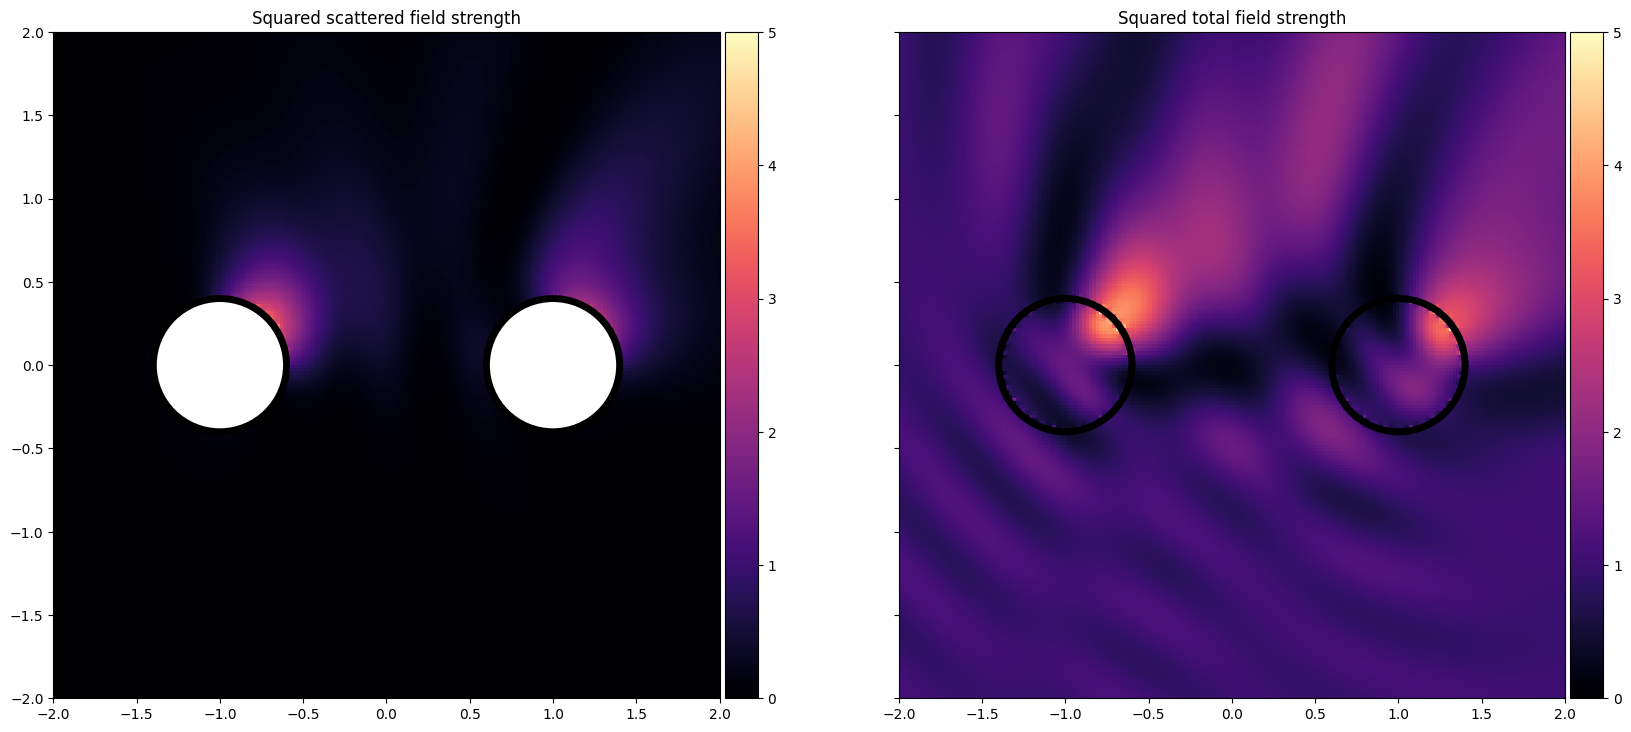

In [9]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
plt.rcParams['figure.figsize'] = (20, 16) # Increase the figure size in the notebook

# First compute the scattered field
scattered_field = np.empty((3, points.shape[1]), dtype='complex128')
scattered_field[:, :] = np.nan
scattered_field[:, exterior_indices] = exterior_values

# Now compute the total field
total_field = np.empty((3, points.shape[1]), dtype='complex128')

for ext_ind in np.arange(points.shape[1])[exterior_indices]:
    total_field[:, ext_ind] = scattered_field[:, ext_ind] + plane_wave(points[:, ext_ind])
total_field[:, interior_indices0] = interior_values0
total_field[:, interior_indices1] = interior_values1
    
# Compute the squared field density
squared_scattered_field = np.sum(np.abs(scattered_field)**2, axis=0)
squared_total_field = np.sum(np.abs(total_field)**2, axis=0)

# Show the resulting images
scattered_image = squared_scattered_field.reshape(nx, ny).T
total_image = squared_total_field.reshape(nx, ny).T
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

f0 = axes[0].imshow(scattered_image, origin='lower', cmap='magma',
                    extent=[-2, 2, -2, 2], vmin=0, vmax=5)
axes[0].add_patch(
    Circle((-1, 0), .4, facecolor='None', edgecolor='k', lw=5)
)
axes[0].add_patch(
    Circle((1, 0), .4, facecolor='None', edgecolor='k', lw=5)
)


axes[0].set_title("Squared scattered field strength")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(f0, cax=cax)

f1 = axes[1].imshow(total_image, origin='lower', cmap='magma',
                    extent=[-2, 2, -2, 2], vmin=0, vmax=5)
axes[1].add_patch(
    Circle((-1, 0), .4, facecolor='None', edgecolor='k', lw=5)
)
axes[1].add_patch(
    Circle((1, 0), .4, facecolor='None', edgecolor='k', lw=5)
)


axes[1].set_title("Squared total field strength")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(f1, cax=cax)

plt.show()

Plotting the bistatic RCS is also easy. The code below demonstrates this.

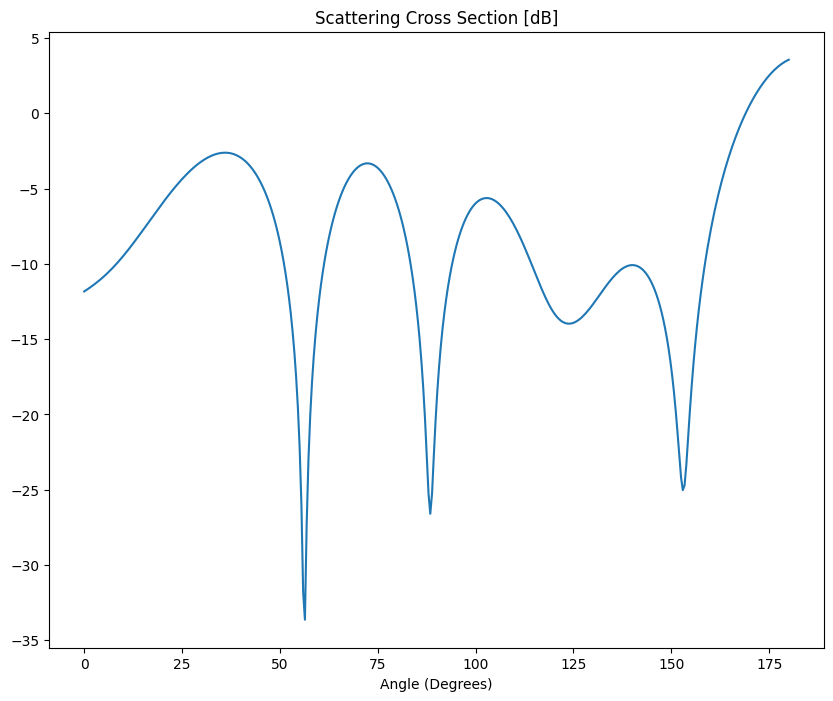

In [10]:
number_of_angles = 400
angles = np.pi * np.linspace(0, 1, number_of_angles)
unit_points = np.array([-np.cos(angles), -np.sin(angles), np.zeros(number_of_angles)])

far_field = np.zeros((3, number_of_angles), dtype='complex128')

for i in range(2):
    electric_far = bempp.api.operators.far_field.maxwell.electric_field(sol[2 * i + 1].space, unit_points, k_ext)
    magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(sol[2 * i].space, unit_points, k_ext)    
    far_field += -electric_far * sol[2 * i + 1] - magnetic_far * sol[2 * i]
    
plt.rcParams['figure.figsize'] = (10, 8) # Resize the figure

cross_section = 10 * np.log10(4 * np.pi * np.sum(np.abs(far_field)**2, axis=0))
plt.plot(angles * 180 / np.pi, cross_section)
plt.title("Scattering Cross Section [dB]")
_ = plt.xlabel('Angle (Degrees)')